In [1]:
import numpy as np
import control
import matplotlib.pyplot as plt

In [2]:

#%% Quanser Aero Parameters
#% Moment of Inertia of helicopter body (kg-m^2)
L_body = 6.5*0.0254#; % length of horizontal body (metal tube)
m_body = 0.094#; % mass of horizontal body (metal tube) 
J_body = m_body * L_body**2 / 12#; % horizontal cylinder rotating about CM

#% Moment of Inertia of yoke fork that rotates about yaw axis (kg-m^2)
m_yoke = 0.526 # mass of entire yoke assembly (kg)
#% h_yoke = 9*0.0254; % height of yoke assembly (m)
r_fork = 0.04/2 #radius of each fork (approximated as cylinder)
J_yoke = 0.5*m_yoke*r_fork**2

# Moment of Inertia from motor + guard assembly about pivot (kg-m^2)
m_prop = 0.43 # mass of dc motor + shield + propeller shield
#% m_motor = 0.203; % mass of dc motor
r_prop = 6.25*0.0254 #distance from CM to center of pitch axis
J_prop = m_prop * r_prop**2 # using parallel axis theorem


# Equivalent Moment of Inertia about Pitch and Yaw Axis (kg-m^2)
Jp = J_body + 2*J_prop # pitch: body and 2 props
Jy = J_body + 2*J_prop + J_yoke # yaw: body, 2 props, and yoke

# Thrust-torque constant (N-m/V) [found experimentally]
Kpp = 0.0011 # (pre-production unit: 0.0015)
Kyy = 0.0022 # (pre-production unit: 0.0040)
Kpy = 0.0021 # thrust acting on pitch from yaw (pre-production unit: 0.0020)
Kyp = -0.0027  # thrust acting on yaw from pitch (pre-production unit: -0.0017)

# Stiffness (N-m/rad)[found experimentally] 
Ksp = 0.037463
 
# Viscous damping (N-m-s/rad) [found experimentally]
Dp = 0.0071116 #pitch axis (pre-production unit: Dp = 0.0226) 
Dy = 0.0220 #yaw axis (pre-production unit: Dy = 0.0211)

A = np.array([[0, 0, 1, 0],[0, 0, 0, 1],[-Ksp/Jp, 0, -Dp/Jp, 0],[0, 0, 0, -Dy/Jy]])
B = np.array([[0, 0],[0, 0],[Kpp/Jp, Kpy/Jp],[Kyp/Jy, Kyy/Jy]])
C = np.eye(2,4)
D = np.zeros([2,2])


Q = np.diag([200, 75, 0, 0 ])
R = 0.005*np.eye(2,2);
K,S,E = control.lqr(A,B,Q,R)
print(K)
print()
Y=np.array([0.5,0.5,0.1,0.1])


[[  98.20881346 -103.06449584   32.26425961  -29.07500828]
 [ 156.34686062   66.164263     45.51218874   17.10683172]]



In [3]:
Y=np.array([0.0010,0.0010,0.0010,0.000])
u=np.matmul(K,np.transpose(Y))
print(np.matmul(A,Y))
print(np.matmul(B,u))
print()
print(f(1,np.append(Y,u)))



[ 0.001       0.         -0.00203659  0.        ]
[0.         0.         0.0270938  0.02344701]



NameError: name 'f' is not defined

In [6]:
def rk4(x, h, y, f):  
    
    k1 = h * f(x, y)
    k2 = h * f(x + 0.5*h, y + make_state_inc1(0.5*k1))
    k3 = h * f(x + 0.5*h, y + make_state_inc1(0.5*k2))
    k4 = h * f(x + h, y + make_state_inc1(k3))
    return x + h, y[0:4] + (k1 + 2*(k2 + k3) + k4)/6.0

def newton(x,h,y,f):
    return x+h,h*f(x,y)

In [63]:
def f(t,state):
    
    x = state[0:4]
    u = state[4:6]
   
    return np.matmul(A,x)+np.matmul(B,u)

def make_state_inc(state):
    return (np.append(state,np.matmul(K,state)), np.matmul(K,state))

  0.000000   1.500000


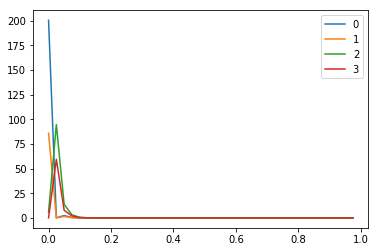

In [78]:
t0 = 0
endt = 1
dt = 1.0/40
Y = [3.5,1.5,0.1,0.0] #  positionm

state = Y
print('%10f %10f' % (t0, state[1]))
t_vec = np.arange(t0,endt,dt)
state_vector = np.zeros([int(endt/dt),4])
state_vector[0] = state

response_vector = np.zeros([int(endt/dt),2])

for i,t in enumerate(t_vec[:-1]):
    state_inc,u = make_state_inc(state)
    
    t, state = newton(t, dt, state_inc, f)
    
    state_vector[i+1] = state
    response_vector[i+1] = u
    #print('%10f %10f' % (t, state[0]))
plt.plot(t_vec,state_vector[:,0]*180/np.pi,label="0")
plt.plot(t_vec,state_vector[:,1]*180/np.pi,label="1")
plt.plot(t_vec,state_vector[:,2]*180/np.pi,label="2")
plt.plot(t_vec,state_vector[:,3]*180/np.pi,label="3")
plt.legend()
plt.show()


In [79]:
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
import io

model = Sequential()
model.add(Dense(10,input_shape=(4,)))
model.add(Dense(10))
def custom_activation(x):
    return (K.tanh(x/8) *24)

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

model.add(Dense(2,activation=custom_activation))

model.compile(loss='mean_squared_error',optimizer='sgd',metrics=['accuracy'])


/Users/Winston/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
